Zeynep Sıla Kaya
2016877

References:
* Lab-1
* Lab-2
* Lab-3
* https://adversarial-ml-tutorial.org/adversarial_training/

In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torchvision as tv
import torch.nn.functional as functional
from tqdm.notebook import tqdm
import itertools

from DBN import DBN

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

True
cuda



I decided to use the Fashion MNIST dataset because it offers a more interesting and practical challenge compared to the traditional MNIST digits. It contains images of clothing items like shirts, shoes, and bags, which makes it a better fit for exploring real-world classification problems and testing the model's ability to work with more complex visual data.The dataset consists of grayscale images representing 10 different types of clothing, including shirts, t-shirts, shoes, and more. It contains a total of 70,000 samples, with 60,000 used for training and the remaining 10,000 reserved for testing.

In [ ]:
%%capture
fashion_mnist_tr = tv.datasets.FashionMNIST(root="../fashion", train=True, download=True)
fashion_mnist_te = tv.datasets.FashionMNIST(root="../fashion", train=False, download=True)

In [ ]:
fashion_mnist_tr.data = fashion_mnist_tr.data / 255
fashion_mnist_te.data = fashion_mnist_te.data / 255

In [ ]:
fashion_mnist_tr.data = fashion_mnist_tr.data.to(device)
fashion_mnist_te.data = fashion_mnist_te.data.to(device)
fashion_mnist_tr.targets = fashion_mnist_tr.targets.to(device)
fashion_mnist_te.targets = fashion_mnist_te.targets.to(device)

In [ ]:
fashion_mnist_tr

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../fashion
    Split: Train

In the following cell, I display every unique piece of clothing from the Fashion MNIST dataset, corresponding to its label. Each label represents a different category of clothing or accessory, such as T-shirt/top (0), Trouser (1), Pullover (2), and so on. This visualization helps in understanding the variety of items the dataset contains and provides a clearer context for the classification task.
Labels:
0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

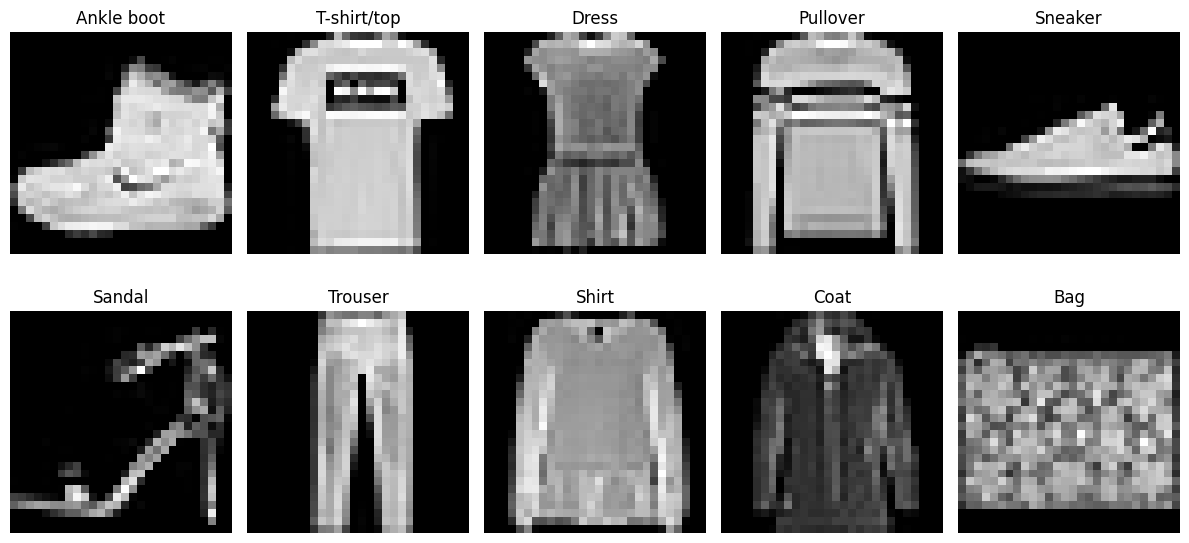

In [ ]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Find one example for each clothing item
unique_classes = {}
for image, label in zip(fashion_mnist_tr.data, fashion_mnist_tr.targets):
    label = label.item()  # Convert tensor to a scalar
    if label not in unique_classes:
        unique_classes[label] = image
    if len(unique_classes) == len(class_names):  # Stop when all classes are found
        break

# Plot each unique clothing item
plt.figure(figsize=(12, 6))
for i, (label, image) in enumerate(unique_classes.items()):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.cpu().numpy(), cmap="gray")  # Convert tensor to NumPy array for plotting
    plt.title(class_names[label])
    plt.axis("off")

plt.tight_layout()
plt.show()

# Training a DBN

I trained my DBN with the following parameters: hidden_units=[600, 800, 1000] (hidden layer sizes), learning_rate=0.05, learning_rate_decay=False, initial_momentum=0.4, final_momentum=0.9, num_epochs=75, and batch_size=64. I found these parameters through trial and error. Initially, I attempted fine-tuning, but it took too long, and my Google Colab session would disconnect, so I continued with trial-and-error adjustments.

For the layer sizes, I decided on [600, 800, 1000] because, during our lab sessions working with the MNIST dataset, we used [400, 500, 800]. Since Fashion MNIST is more complex and involves clothing items with greater variability, I increased the sizes to capture more features and improve the model's ability to learn intricate patterns.

Reducing the learning rate significantly lowered my errors. I initially tried a learning rate of 0.01, which brought the errors down substantially, but they were still slightly high. So, I increased it to 0.05, which worked better. Additionally, increasing the number of epochs from 50 to 75 further reduced the errors, as the model had more time to learn from the data.

In [ ]:
dbn_fmnist = DBN(visible_units=28*28,          # dimensionality of the sensory data
                hidden_units=[600,800,1000], # size of hidden layers
                k=1,                          # reconstruction steps in Contrastive Divergence
                learning_rate=0.05,
                learning_rate_decay=False,
                initial_momentum=0.4,
                final_momentum=0.9,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

In [ ]:
num_epochs = 75
batch_size = 64

dbn_fmnist.train_static(
    fashion_mnist_tr.data,
    fashion_mnist_tr.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.9629     |0.0563       |255.8679   |7.2957     |
|20    |0.8590     |0.0511       |218.3710   |4.8306     |
|30    |0.8275     |0.0499       |210.9212   |4.7658     |
|40    |0.8129     |0.0492       |206.7794   |4.2109     |
|50    |0.8039     |0.0492       |204.7537   |4.6257     |
|60    |0.7993     |0.0490       |203.1799   |4.7205     |
|70    |0.7956     |0.0490       |201.5114   |4.6392     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.5215     |0.0225       |157.5088   |3.2681     |
|20    |0.4626     |0.0192       |142.3475   |2.6942     |
|30    |0.4486     |0.0185       |137.7422   |2.7839     |
|40    |0.4421     |0.0187       |135.3114   |2.6857     |
|50    |0.4393     |0.0186       |133.9384   |2.3965     |
|60    |0.4365     |0.0183       |132.8006   |2.6783     |
|70    |0.4345     |0.0186       

In the upper cell, we can observe the errors go down as we go higher up in the network.

Next, we will visualize the receptive fields of each layer to better understand what the model has learned, similar to what we did in the lab sessions. To do this, we will retrieve the weights for each layer and process them for visualization. Since the raw receptive fields might contain noise, we'll apply a threshold to reduce this and make the patterns more discernible. Additionally, the weights of each field can have different ranges, so we'll normalize them using min-max scaling to allow for fair comparison across fields. Finally, we will plot a subset of the receptive fields to observe the learned representations.

# Visualizing Receptive Fields

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

Outputs of the receptive fields from the first layer.

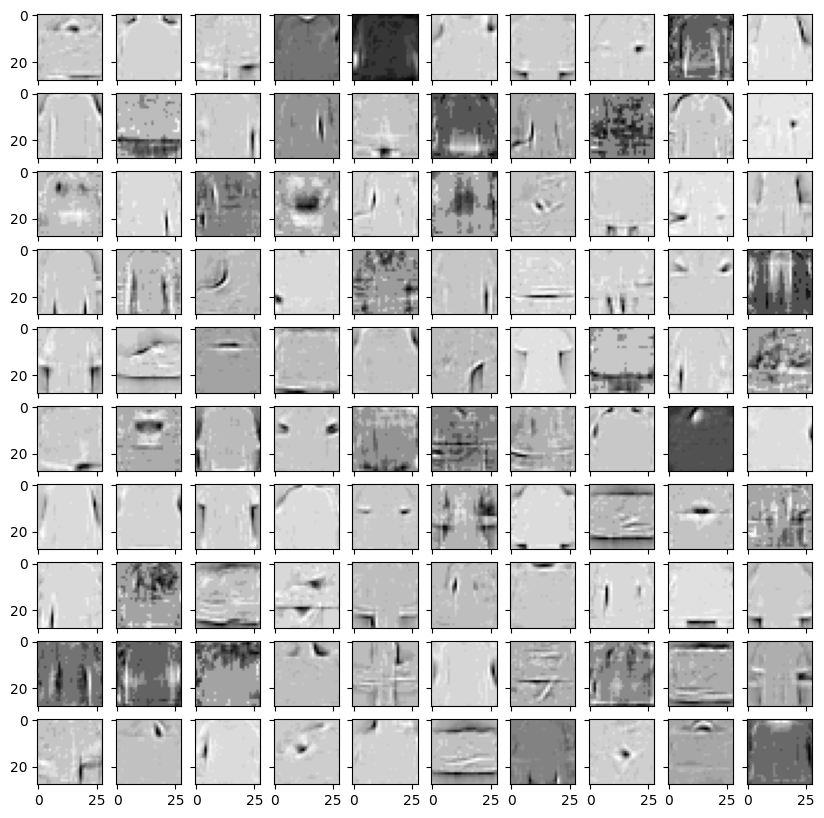

In [ ]:
w1 = get_weights(dbn_fmnist, layer=0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

The weights in the subsequent layers differ in dimensionality from the Fashion MNIST images. To visualize the receptive fields as images, we need to reshape the vectors to a size of 28 × 28. For the second layer's receptive field outputs, we will project the weights from the first layer onto the second layer. This process will be repeated for the third as well.

Outputs of the receptive fields from the second layer.

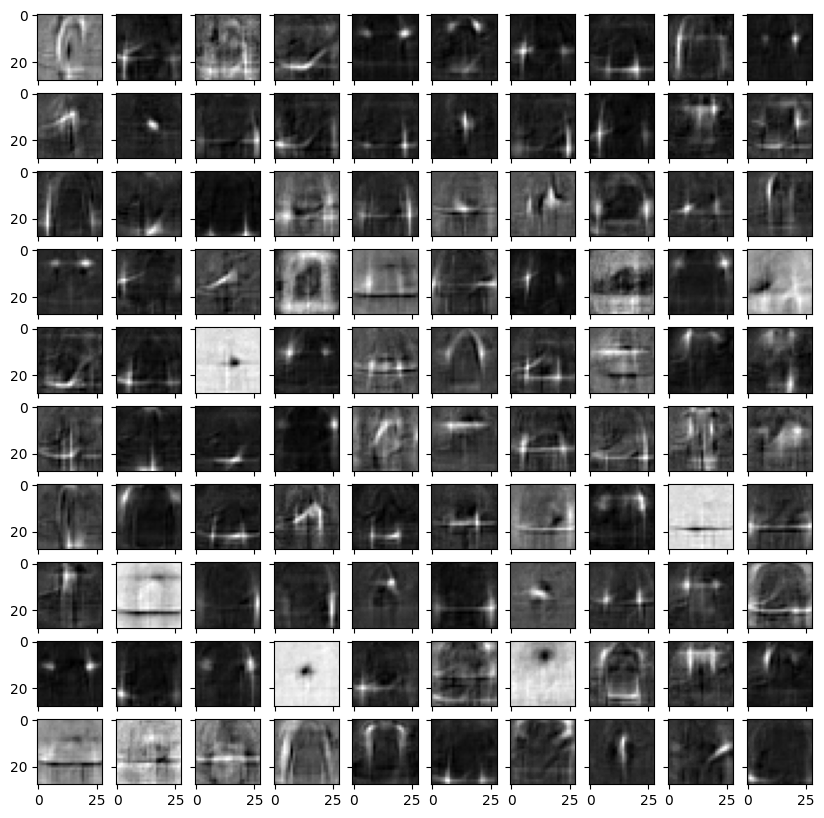

In [ ]:
w1 = get_weights(dbn_fmnist, layer=0)
w2 = get_weights(dbn_fmnist, layer=1)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)

w_product = (w1 @ w2)  # here we do the projection
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)

Finally, outputs of the receptive fields from the third layer.

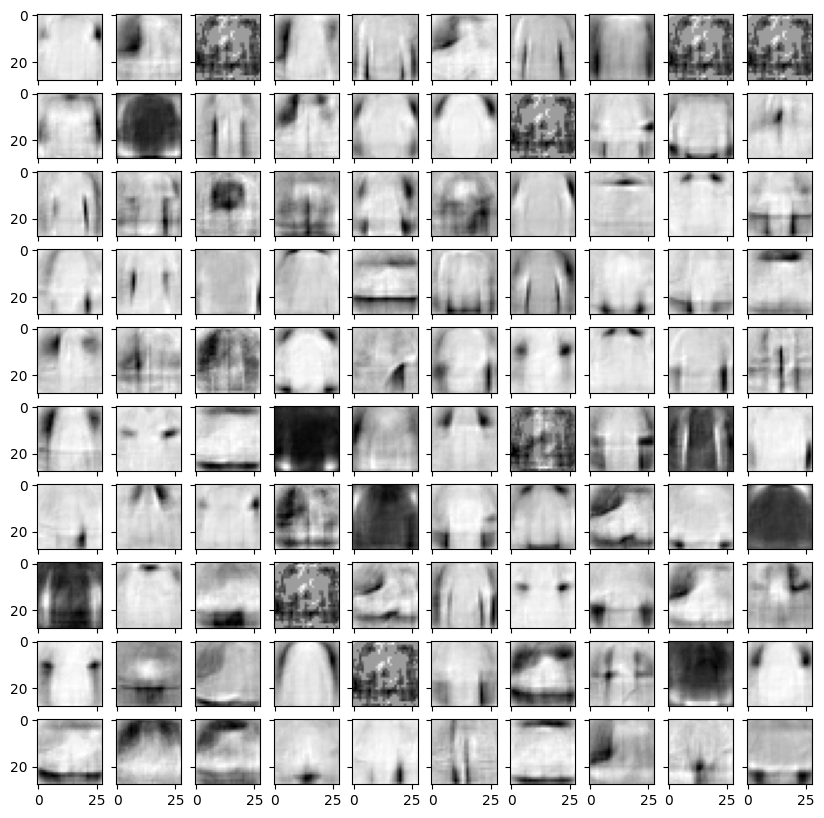

In [ ]:
w1 = get_weights(dbn_fmnist, layer=0)
w2 = get_weights(dbn_fmnist, layer=1)
w3 = get_weights(dbn_fmnist, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)  # here we do the projection
w_product_23 = (w_product_12 @ w3)  # here we do the projection
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)

As we progress through the layers, the complexity of the receptive fields increases. The first layer captures basic, low-level features like edges and textures, forming the foundation for feature extraction. The second layer combines these into more structured patterns, such as curves and intermediate textures, showing a balance between detail and abstraction. By the third layer, the receptive fields become more abstract and distributed, capturing high-level, global patterns that represent the overall structure of the clothing items.This hierarchical progression highlights how the DBN learns increasingly complex and abstract representations as we move deeper into the network, with each layer building on the outputs of the previous one to better understand the data.

# Clustering Internal Representations

We can analyze the relationships between the learned distributed representations of the layers. Using hierarchical clustering, we can group the representations based on their similarities. First, we compute the requested layer’s representation, then calculate the centroids of the representations filtered by their labels. Finally, we apply the clustering algorithm to organize and visualize the relationships between these class-wise representations.

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_fmnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [ ]:
hidden_repr_1 = get_kth_layer_repr(fashion_mnist_tr.data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)
print(hidden_repr_1.shape)
print(hidden_repr_2.shape)
print(hidden_repr_3.shape)

torch.Size([60000, 600])
torch.Size([60000, 800])
torch.Size([60000, 1000])


In [ ]:
def get_mask(label):  # we use this function to filter by class
  labels = fashion_mnist_tr.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_repr):
  hidden_repr_np = hidden_repr.cpu().numpy()
  return {
    label: hidden_repr_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_repr):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [ ]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_3)

In [ ]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

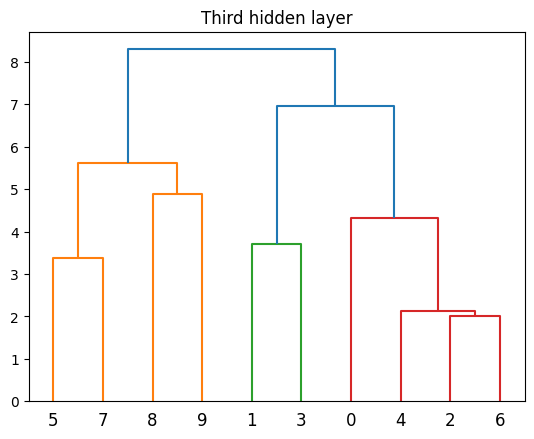

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

# Linear Read-out

Similarly, another approach is to assess the distributed representations by employing a linear readout at each layer of the DBN. We're accessing the layers through the RBM to retrieve the weights of each layer and initialize them in the linear model defined. Using the actual targets from the dataset, we train the linear classifier on the hidden representations to evaluate how well each layer encodes the information needed for classification.

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [ ]:
layer_size = dbn_fmnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_fmnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_fmnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

In [ ]:
def train_linear(linear, hidden_reprs):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = 1000

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = fashion_mnist_tr.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [ ]:
train_linear(linear1, hidden_repr_1)

epoch :   1/1000, loss = 2.3401
epoch : 101/1000, loss = 0.8245
epoch : 201/1000, loss = 0.6676
epoch : 301/1000, loss = 0.6018
epoch : 401/1000, loss = 0.5625
epoch : 501/1000, loss = 0.5353
epoch : 601/1000, loss = 0.5148
epoch : 701/1000, loss = 0.4987
epoch : 801/1000, loss = 0.4855
epoch : 901/1000, loss = 0.4745


In [ ]:
train_linear(linear2, hidden_repr_2)

epoch :   1/1000, loss = 2.3122
epoch : 101/1000, loss = 0.7454
epoch : 201/1000, loss = 0.6220
epoch : 301/1000, loss = 0.5674
epoch : 401/1000, loss = 0.5340
epoch : 501/1000, loss = 0.5108
epoch : 601/1000, loss = 0.4934
epoch : 701/1000, loss = 0.4797
epoch : 801/1000, loss = 0.4686
epoch : 901/1000, loss = 0.4594


In [ ]:
train_linear(linear3, hidden_repr_3)

epoch :   1/1000, loss = 2.3154
epoch : 101/1000, loss = 0.7727
epoch : 201/1000, loss = 0.6314
epoch : 301/1000, loss = 0.5721
epoch : 401/1000, loss = 0.5368
epoch : 501/1000, loss = 0.5125
epoch : 601/1000, loss = 0.4944
epoch : 701/1000, loss = 0.4802
epoch : 801/1000, loss = 0.4687
epoch : 901/1000, loss = 0.4592


In [ ]:
hidden_repr_1_test = get_kth_layer_repr(fashion_mnist_te.data, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

In [ ]:
# compute the classifier predictions:
predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [ ]:
compute_accuracy(predictions_test1, fashion_mnist_te.targets)

0.8317999839782715

In [ ]:
compute_accuracy(predictions_test2, fashion_mnist_te.targets)

0.8328999876976013

In [ ]:
compute_accuracy(predictions_test3, fashion_mnist_te.targets)

0.8325999975204468

# Comparion with a Feed-Forward Neural Network


Next, we will train a simple feed-forward neural network with the same structure as the DBN. This will allow us to compare a non-linear model trained end-to-end for classification with a linear classifier that uses the representations learned by the DBN in an unsupervised manner to solve the same task.

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [ ]:
ffnn = Feedforward(600,800,1000).to(device)

In [ ]:
def train_supervised(network, input_data, epochs=1000):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input_data).squeeze()
    targets = fashion_mnist_tr.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [ ]:
train_supervised(ffnn, fashion_mnist_tr.data.reshape((60000, 784)), 1050)

epoch :   1/1050, loss = 2.3031
epoch : 101/1050, loss = 1.3451
epoch : 201/1050, loss = 0.8939
epoch : 301/1050, loss = 0.7492
epoch : 401/1050, loss = 0.6637
epoch : 501/1050, loss = 0.6040
epoch : 601/1050, loss = 0.5657
epoch : 701/1050, loss = 0.5265
epoch : 801/1050, loss = 0.5104
epoch : 901/1050, loss = 0.4883
epoch : 1001/1050, loss = 0.4859


In [ ]:
predictions_ffnn = ffnn(fashion_mnist_te.data.reshape((10000, 784)))

In [ ]:
compute_accuracy(predictions_ffnn, fashion_mnist_te.targets)

0.8241999745368958

We can say that the accuracies of our model's layers are little bit higher or almost the same.

Plotting confusion matrices for our DBN network layers.

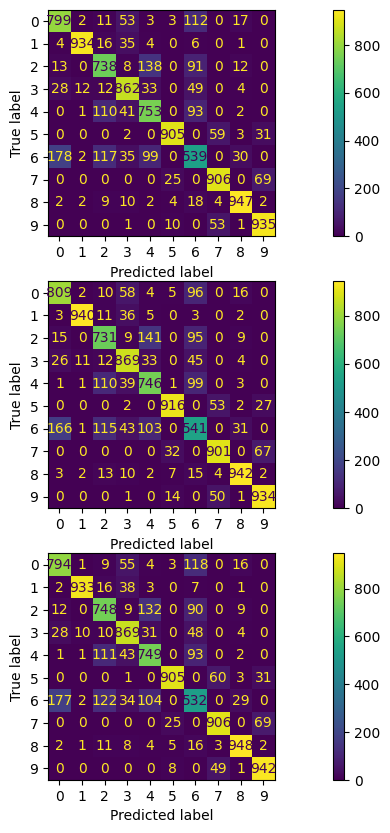

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

prediction_indices_1 = predictions_test1.max(axis=1).indices
prediction_indices_2 = predictions_test2.max(axis=1).indices
prediction_indices_3 = predictions_test3.max(axis=1).indices

cm1 = confusion_matrix(fashion_mnist_te.targets.cpu(), prediction_indices_1.cpu())
cm2 = confusion_matrix(fashion_mnist_te.targets.cpu(), prediction_indices_2.cpu())
cm3 = confusion_matrix(fashion_mnist_te.targets.cpu(), prediction_indices_3.cpu())

ConfusionMatrixDisplay(cm1).plot(ax=axes[0])
ConfusionMatrixDisplay(cm2).plot(ax=axes[1])
ConfusionMatrixDisplay(cm3).plot(ax=axes[2])

Plotting the FFNN model's confusion matrix.

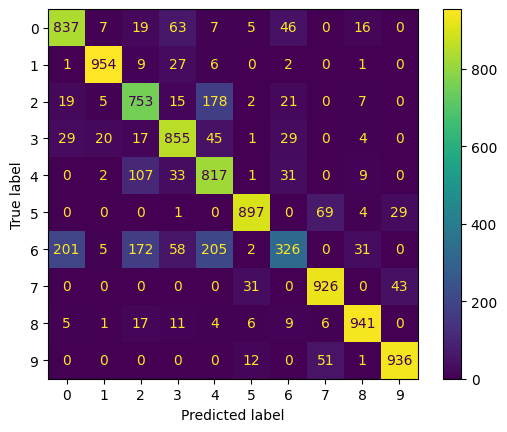

In [ ]:
prediction_indices_ffnn = predictions_ffnn.max(axis=1).indices

cm_ffnn = confusion_matrix(fashion_mnist_te.targets.cpu(), prediction_indices_ffnn.detach().cpu())
ConfusionMatrixDisplay(cm_ffnn).plot()

We observe that most models struggle to differentiate class 6 (shirts) from class 0 (T-shirts), class 2 (pullovers), and class 4 (coats) due to their similarities. Additionally, class 2 (pullovers) is often confused with class 4 (coats). These errors are expected, as the items in these categories look very alike.

# Robustness to Noise

In [ ]:
def inject_noise(data, noise_level):
  random_gaussian_tensor = torch.randn(data.shape,device=device) * noise_level
  noisy_data = data + random_gaussian_tensor

  return noisy_data

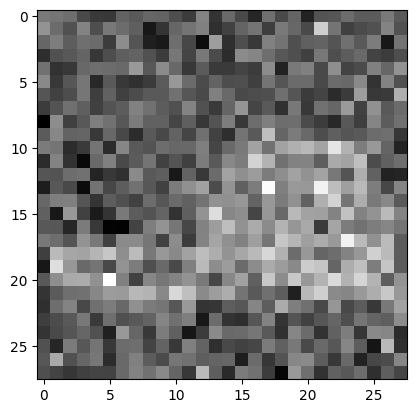

In [ ]:
noise_level = 0.3
fmnist_test_with_noise = inject_noise(fashion_mnist_te.data, noise_level)
__ = plt.imshow(fmnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

In [ ]:
def get_accuracy_values_at_noise_level(noise_level):

  fmnist_test_with_noise = inject_noise(fashion_mnist_te.data, noise_level)  # first, let's create noisy test images

  hidden_repr_1_noisy = get_kth_layer_repr(fmnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_2_noisy = get_kth_layer_repr(hidden_repr_1_noisy, 1, device)
  hidden_repr_3_noisy = get_kth_layer_repr(hidden_repr_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, fashion_mnist_te.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, fashion_mnist_te.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, fashion_mnist_te.targets)

  ### TASK: repeat a similar process for the feed-forward model (NB: make sure you reshape the input data appropriately!)
  predictions_ffnn_noisy = ffnn(fmnist_test_with_noise.reshape((10000, 784)))
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy,fashion_mnist_te.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [ ]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.803
Accuracy of H2 read-out: 0.819
Accuracy of H3 read-out: 0.821
Accuracy of FF network : 0.794


In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

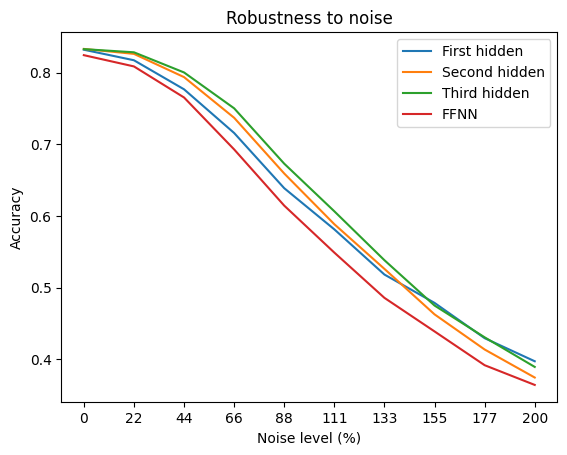

In [ ]:
noise_levels = np.linspace(0,2,10)
plot_noise_robustness_curves(noise_levels)

We can observe that third and second layers are more robust to noise while FFNN performs the worst as we increase the noise level.

# Perturbing the Models with Adversarial Attacks

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

## Adversarial Samples


We need to define a unified architecture incorporating the DBN + readout layers, which allows to compute the gradient of the loss (classification task) with respect to the input data that is being processed.

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readout):
        super().__init__()
        self.readout = readout
        self.readout_level = 2
        self.dbn_mnist = dbn_mnist
        self._require_grad()

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM activations
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readout.forward(hidden_states[self.readout_level])

In [ ]:
dbn_with_readout = DBNWithReadOut(dbn_fmnist, linear3)

Let's see what an adversiarial sample looks like. Let't take one sample from the test set:

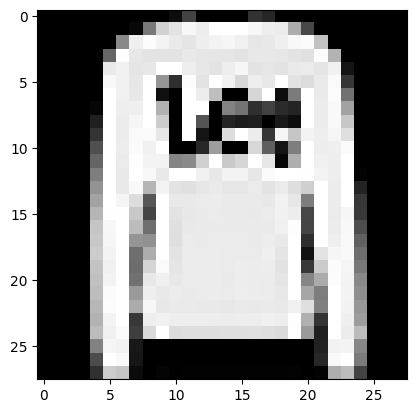

In [ ]:
test_sample_idx = 1
test_image = fashion_mnist_te.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'), cmap = 'gray')

Let's classify this "clean" image using one of the models we previously trained and then modify the image to attack the network.

In [ ]:
attacked_model = dbn_with_readout

In [ ]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 2.


It correctly classified it as class 2 (Pullover).

Let's create and visualize the corresponding adversarial sample.

In [ ]:
epsilon = 0.3  # strenght of the attack
test_image_label = fashion_mnist_te.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward(retain_graph=True)
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss

perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

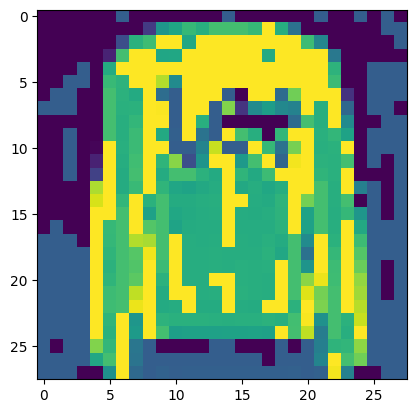

In [ ]:
_ = plt.imshow(perturbed_image.cpu().detach().numpy().reshape(28, 28))

In [ ]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 6.


As we can see after perturbing the image, the model misclassified it as class 6 (shirt).

## Resisting to Adversarial Attacks

Let's now compare the ability to resist to adversarial attacks of our two models: the feedforward network and the DBN.

We will also test the ability of the DBN to reduce the impact of the attack by performing one "top-down" reconstruction step, from the hidden representation of the last layer to the visible units, and back to the hidden representation.

In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0  # count number of correct classifications
    print_reconstruction = num_steps > 0  # if we request for top-down reconstruction, show the resulting image

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # we need to get the gradient to perform the attack

        output = model.forward(data)  # forward pass through the model

        init_pred = torch.argmax(output)  # prediction before the attack

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss_value = torch.nn.functional.cross_entropy(output, target) # get loss value
        model.zero_grad()
        loss_value.backward()
        data_grad = data.grad.data  # collect the gradient with respect to the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)  # call the attack function previously defined

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()

        # If requested, reconstruct the input iterating bottom-up and top-down sampling
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [ ]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=True, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.46MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 171kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.18MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.86MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Let's measure the accuracy of the FFNN model.

In [ ]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 0.95%



Let's now compare compare with the read-out trained on the hidden representations of the DBN:

In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.2
Test Accuracy: 10.89%



And finally let's test whether using one step of top-down reconstruction from the generative model allows to improve resilience to attacks:

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



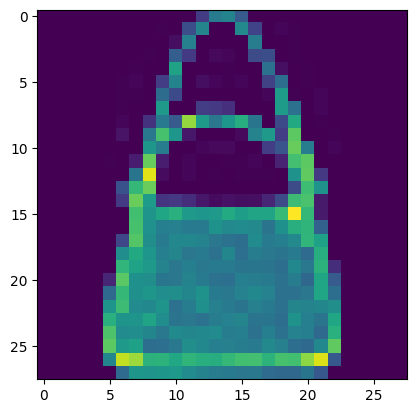


Here's a perturbed sample:



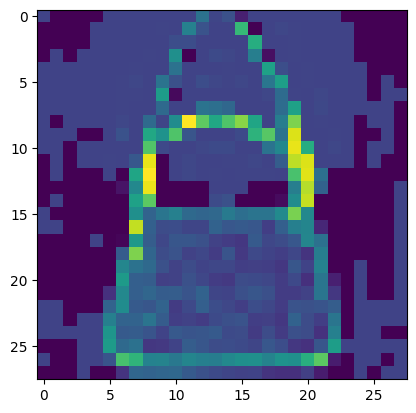


Here's what a 1-steps reconstructed sample looks like:



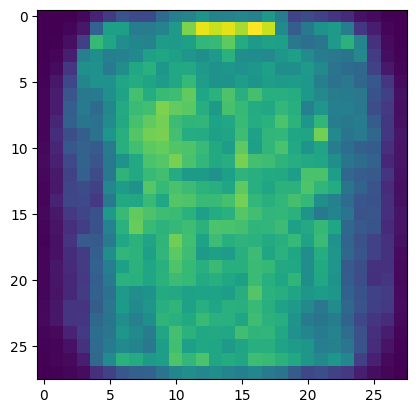


Epsilon: 0.2
Test Accuracy: 10.42%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.2,
                                      num_steps=1)

Compared to FFNN, our DBN performed better.

## Effect of the noise parameter $\epsilon$

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)  # set verbose to False to avoid displaying too many images
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=2)

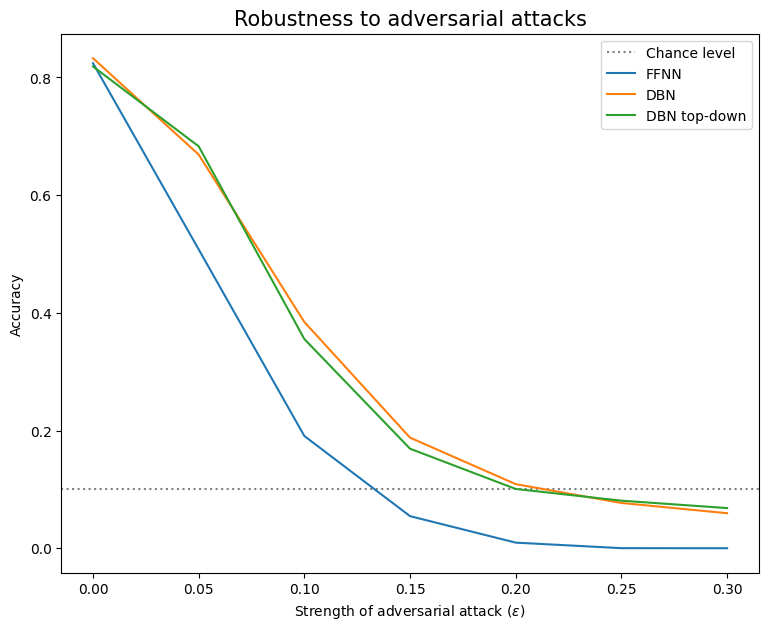

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

## Using Adversarial Training as a Way of Defending Against Adversarial Attacks


In the last part, I trained two CNN models to compare their performance: one trained on clean data and the other using adversarial samples generated with the FGSM attack. I tracked the train, test, and adversarial errors for both models to evaluate their robustness. Finally, I visualized the results to highlight the impact of adversarial training on model performance.

In [ ]:
fmnist_train = tv.datasets.FashionMNIST("/data_at", train=True, download=True, transform=tv.transforms.ToTensor())
fmnist_test = tv.datasets.FashionMNIST("/data_at", train=False, download=True, transform=tv.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(fmnist_train, batch_size = 64, shuffle=True)
test_loader = torch.utils.data.DataLoader(fmnist_test, batch_size = 64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.7MB/s]


Extracting /data_at/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data_at/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 169kB/s]


Extracting /data_at/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data_at/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.19MB/s]


Extracting /data_at/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data_at/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 24.6MB/s]

Extracting /data_at/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data_at/FashionMNIST/raw



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1, stride=2), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1, stride=2), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7 * 7 * 64, 100), nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# FGSM Attack
def fgsm_attack(model, X, y, epsilon=0.1):
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

In [ ]:
# Standard Epoch
def epoch(loader, model, opt=None):
    total_loss, total_err = 0., 0.
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp, y)

        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.argmax(dim=1) != y).sum().item()
        total_loss += loss.item() * X.shape[0]

    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [ ]:
# Adversarial Epoch
def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    total_loss, total_err = 0., 0.
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X + delta)
        loss = nn.CrossEntropyLoss()(yp, y)

        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.argmax(dim=1) != y).sum().item()
        total_loss += loss.item() * X.shape[0]

    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [121]:
# Initialize and train the standard CNN model
model_cnn = CNN().to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=1e-1)

# Store errors for standard CNN
std_train_errors, std_test_errors, std_adv_errors = [], [], []

for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, optimizer)
    test_err, test_loss = epoch(test_loader, model_cnn)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_cnn, fgsm_attack)

    # Adjust learning rate at epoch 5
    if t == 4:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 1e-2

    # Save errors for plotting
    std_train_errors.append(train_err)
    std_test_errors.append(test_err)
    std_adv_errors.append(adv_err)

    # Print errors
    print(f"Epoch {t+1}/10")
    print(f"Train Error: {train_err:.6f}, Test Error: {test_err:.6f}, Adversarial Error: {adv_err:.6f}")
    print("-" * 50)

Epoch 1/10
Train Error: 0.261233, Test Error: 0.156100, Adversarial Error: 0.900600
--------------------------------------------------
Epoch 2/10
Train Error: 0.137083, Test Error: 0.139800, Adversarial Error: 0.924600
--------------------------------------------------
Epoch 3/10
Train Error: 0.114000, Test Error: 0.120600, Adversarial Error: 0.988000
--------------------------------------------------
Epoch 4/10
Train Error: 0.102700, Test Error: 0.110200, Adversarial Error: 0.986300
--------------------------------------------------
Epoch 5/10
Train Error: 0.094617, Test Error: 0.112300, Adversarial Error: 0.985600
--------------------------------------------------
Epoch 6/10
Train Error: 0.074500, Test Error: 0.095700, Adversarial Error: 0.976900
--------------------------------------------------
Epoch 7/10
Train Error: 0.070883, Test Error: 0.095300, Adversarial Error: 0.962800
--------------------------------------------------
Epoch 8/10
Train Error: 0.069883, Test Error: 0.092800,

The CNN model trained on the clean dataset performs well on unperturbed images, with error rates of approximately 0.06 on the training set and 0.09 on the test set. However, its error rate on adversarial samples rises significantly to 0.98, indicating that the model struggles and makes numerous mistakes when faced with adversarially perturbed inputs.

In [122]:
# Initialize and train the adversarially trained CNN model
adv_model_cnn = CNN().to(device)
optimizer = torch.optim.SGD(adv_model_cnn.parameters(), lr=1e-1)

# Store errors for adversarially trained CNN
adv_train_errors, adv_test_errors, adv_adv_errors = [], [], []

for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, adv_model_cnn, fgsm_attack, optimizer)
    test_err, test_loss = epoch(test_loader, adv_model_cnn)
    adv_err, adv_loss = epoch_adversarial(test_loader, adv_model_cnn, fgsm_attack)

    # Adjust learning rate at epoch 5
    if t == 4:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 1e-2

    # Save errors for plotting
    adv_train_errors.append(train_err)
    adv_test_errors.append(test_err)
    adv_adv_errors.append(adv_err)

    # Print errors
    print(f"Epoch {t+1}/10")
    print(f"Train Error: {train_err:.6f}, Test Error: {test_err:.6f}, Adversarial Error: {adv_err:.6f}")
    print("-" * 50)

Epoch 1/10
Train Error: 0.501283, Test Error: 0.286200, Adversarial Error: 0.375200
--------------------------------------------------
Epoch 2/10
Train Error: 0.311050, Test Error: 0.204500, Adversarial Error: 0.303200
--------------------------------------------------
Epoch 3/10
Train Error: 0.271600, Test Error: 0.179700, Adversarial Error: 0.268400
--------------------------------------------------
Epoch 4/10
Train Error: 0.253133, Test Error: 0.176000, Adversarial Error: 0.298900
--------------------------------------------------
Epoch 5/10
Train Error: 0.237950, Test Error: 0.159000, Adversarial Error: 0.235900
--------------------------------------------------
Epoch 6/10
Train Error: 0.214667, Test Error: 0.150700, Adversarial Error: 0.228900
--------------------------------------------------
Epoch 7/10
Train Error: 0.211983, Test Error: 0.148700, Adversarial Error: 0.227100
--------------------------------------------------
Epoch 8/10
Train Error: 0.210717, Test Error: 0.149700,

There is a noticeable difference compared to the previous model. While the errors on the train and test sets have increased, the error on adversarial samples has decreased significantly to 0.22. This shows that training the model using adversarial samples improves its resistance to such attacks.

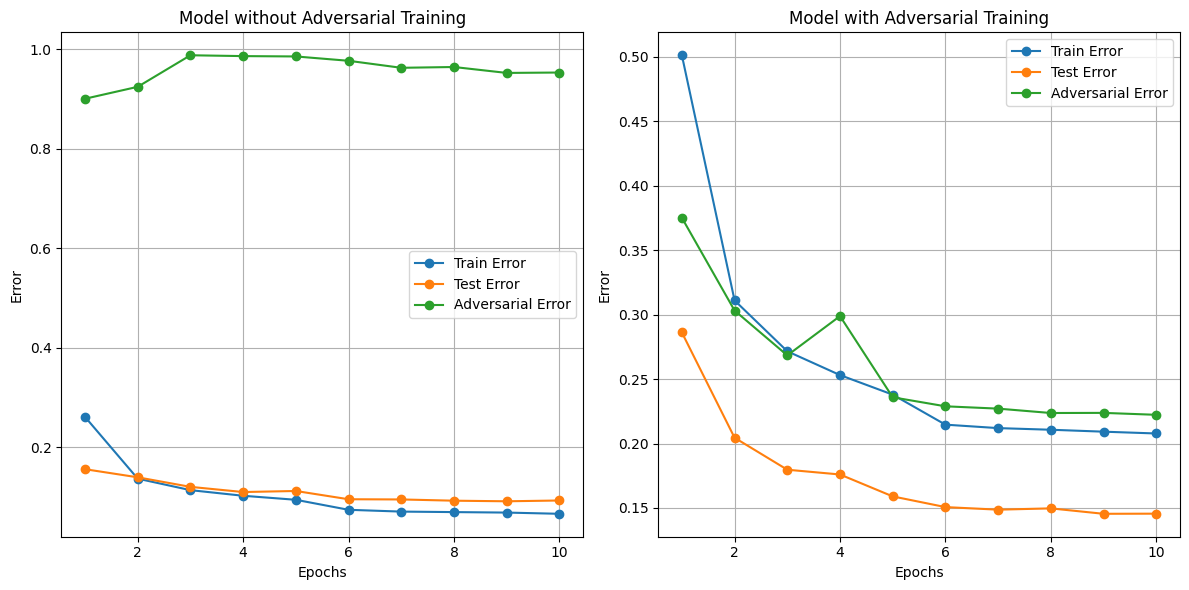

In [123]:
# Plot comparison
plt.figure(figsize=(12, 6))

# Plot for the first model (no adversarial training)
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), std_train_errors, label='Train Error', marker='o')
plt.plot(range(1, 11), std_test_errors, label='Test Error', marker='o')
plt.plot(range(1, 11), std_adv_errors, label='Adversarial Error', marker='o')
plt.title('Model without Adversarial Training')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

# Plot for the second model (with adversarial training)
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), adv_train_errors, label='Train Error', marker='o')
plt.plot(range(1, 11), adv_test_errors, label='Test Error', marker='o')
plt.plot(range(1, 11), adv_adv_errors, label='Adversarial Error', marker='o')
plt.title('Model with Adversarial Training')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()